# CareHarmony Case Study

You will be using the CMS 2008-2010 Data Entrepreneurs Synthetic PUF beneficiary data files for this project. This dataset is a bit old, but it is a large synthetic dataset that closely mirrors the type of data that we work with. Due to file size limitations, each data type in the CMS Linkable 2008-2010 Medicare DE-SynPUF is released in 20 separate samples (essentially each is a .25% sample)

The DE-SynPUF contains five types of data for the period 2008-2010:
* Beneficiary Summary
* Inpatient Claims
* Outpatient Claims
* Carrier Claims (not included in the current analysis)
* Prescription Drug Events (not included in the current analysis)


To keep things simple, you will be primarily utilizing the beneficiary-level files that can be found in the zip file attached. These data files contain high-level summaries of patient demographics, conditions, and spending for each of the years 2008, 2009, and 2010. It is organized into twenty separate files for each year and organized such that the same patients are retained in each of the yearly files sharing the same index number. Ten files per year are included for completeness, but you may use as many as you like to conduct your analysis. Note that the dataset is indeed synthetic so many relationships we would expect to see in real world data may not hold. Accordingly, in our evaluation we will focus more on your analytical approach than the actual results.

The original source of the files can be found at this link: https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DESample01. Translations for a lot of the common terms provided in the Beneficiary Summary file can be found at this link: https://www.cms.gov/files/document/de-10-codebook.pdf-0.

# CareHarmony Case Study: causal modeling

The health system is also considering deploying a newly developed intervention that reduces the likelihood of developing congestive heart failure (CHF) without impacting any other factors of a patient's health. Before deploying the intervention, they would like to estimate its impact in reducing costs due to the new development of CHF. To help answer this question, please use the data to estimate the impact of a patient being developing diagnosis-level CHF on their total cost in the following year.

In [1]:
import os
import time

import pandas as pd
import numpy as np
from datetime import datetime

import sns as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

**Beneficiary data processing**

In [ ]:
start_time = time.time()

# Define the base directory for our CSV files
base_dir = r'C:\code_personal_use\cms\data\bene'

# List of years we have data for
years = [2008, 2009, 2010]

# Columns to use for each year
columns_2008 = [
    'DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD',
    'SP_STATE_CODE', 'BENE_COUNTY_CD', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN',
    'SP_CNCR', 'BENE_ESRD_IND', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES',
    'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP',
    'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

columns_2009_2010 = [
    'DESYNPUF_ID', 'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR',
    'BENE_ESRD_IND', 'SP_COPD', 'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT',
    'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA', 'MEDREIMB_IP', 'BENRES_IP',
    'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP', 'MEDREIMB_CAR',
    'BENRES_CAR', 'PPPYMT_CAR'
]

# Function to recode BENE_ESRD_IND
def recode_bene_esrd_ind(df, column):
    df[column] = df[column].replace({'Y': 1, '0': 2}).astype(int)
    return df

# Function to rename columns with a suffix
def rename_columns_with_suffix(df, suffix):
    df = df.rename(columns=lambda x: x + suffix if x != 'DESYNPUF_ID' else x)
    return df

# Function to load and preprocess a batch of files for a given year
def load_and_preprocess_batch(file_paths, year):
    columns = columns_2008 if year == 2008 else columns_2009_2010
    parse_dates = ['BENE_BIRTH_DT'] if year == 2008 else None
    date_parser = lambda x: pd.to_datetime(x, format='%Y%m%d') if year == 2008 else None

    # Load and preprocess files in the batch
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(
            file_path,
            usecols=columns,
            parse_dates=parse_dates,
            date_parser=date_parser
        )
        df = recode_bene_esrd_ind(df, 'BENE_ESRD_IND')
        df = rename_columns_with_suffix(df, f'_{year}')
        dfs.append(df)

    # Concatenate all DataFrames in the batch
    return pd.concat(dfs, ignore_index=True)

# Create a dictionary to store DataFrames for each year
dfs_by_year = {}

# Process files in batches
batch_size = 5  # Adjust the batch size based on your system's memory
for year in years:
    file_paths = [os.path.join(base_dir, f'DE1_0_{year}_Beneficiary_Summary_File_Sample_{i}.csv') for i in range(1, 20)]
    batches = [file_paths[i:i + batch_size] for i in range(0, len(file_paths), batch_size)]

    # Load and preprocess each batch
    year_dfs = []
    for batch in batches:
        batch_df = load_and_preprocess_batch(batch, year)
        year_dfs.append(batch_df)

    # Concatenate all batches for the year
    dfs_by_year[year] = pd.concat(year_dfs, ignore_index=True)

# Merge DataFrames for all years on DESYNPUF_ID
merged_df = dfs_by_year[2008]
for year in years[1:]:
    merged_df = merged_df.merge(dfs_by_year[year], on='DESYNPUF_ID', how='inner')

# Define the prefixes to check for null values
prefixes = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
    'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Function to replace null values with 0 for specified prefixes
def replace_nulls_with_zero(df, prefixes):
    for prefix in prefixes:
        cols = [col for col in df.columns if col.startswith(prefix)]
        df[cols] = df[cols].fillna(0)
    return df

merged_df = replace_nulls_with_zero(merged_df, prefixes)

# Calculate Age
def calculate_age(birth_date, reference_date):
    return reference_date.year - birth_date.year - ((reference_date.month, reference_date.day) < (birth_date.month, birth_date.day))

reference_date = datetime.now()  # Using the current date as the reference date
merged_df['Age'] = merged_df['BENE_BIRTH_DT_2008'].apply(lambda x: calculate_age(x, reference_date))

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs in 2008: {dfs_by_year[2008]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs in 2009: {dfs_by_year[2009]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs in 2010: {dfs_by_year[2010]["DESYNPUF_ID"].nunique()}')
print(f'Unique IDs after merging: {merged_df["DESYNPUF_ID"].nunique()}')

print("First few rows of the merged DataFrame:")
print(merged_df.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

In [ ]:
merged_df.info()

In [64]:
merged_df.describe(())

,BENE_SEX_IDENT_CD_2008,BENE_RACE_CD_2008,BENE_ESRD_IND_2008,SP_STATE_CODE_2008,BENE_COUNTY_CD_2008,SP_ALZHDMTA_2008,SP_CHF_2008,SP_CHRNKIDN_2008,SP_CNCR_2008,SP_COPD_2008,...,MEDREIMB_IP_2010,BENRES_IP_2010,PPPYMT_IP_2010,MEDREIMB_OP_2010,BENRES_OP_2010,PPPYMT_OP_2010,MEDREIMB_CAR_2010,BENRES_CAR_2010,PPPYMT_CAR_2010,Age
count,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,...,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06,2.142287e+06
mean,1.555706e+00,1.284521e+00,1.929264e+00,2.572132e+01,3.655592e+02,1.807819e+00,1.715481e+00,1.839042e+00,1.936368e+00,1.864491e+00,...,1.244053e+03,1.448212e+02,5.237660e+01,4.336826e+02,1.314106e+02,1.503832e+01,8.477981e+02,2.394512e+02,1.284738e+01,8.713659e+01
std,4.968873e-01,7.543183e-01,2.563828e-01,1.557189e+01,2.661676e+02,3.940147e-01,4.511853e-01,3.674926e-01,2.440971e-01,3.422669e-01,...,5.141761e+03,5.655884e+02,1.379283e+03,1.273109e+03,3.680647e+02,2.774419e+02,9.995214e+02,2.843982e+02,7.319756e+01,1.258293e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-8.000000e+03,0.000000e+00,0.000000e+00,-1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01
50%,2.000000e+00,1.000000e+00,2.000000e+00,2.500000e+01,3.300000e+02,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.400000e+02,1.500000e+02,0.000000e+00,8.800000e+01
max,2.000000e+00,5.000000e+00,2.000000e+00,5.400000e+01,9.990000e+02,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,1.566900e+05,3.730000e+04,8.300000e+04,4.051000e+04,1.104000e+04,1.800000e+04,1.653000e+04,3.590000e+03,3.000000e+03,1.150000e+02


Need to work on optimizing this step. It currently takes a little over 5 mins of run time to finish merging all 20 beneficiary files

In [65]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# merged_df = merged_df[merged_df['DESYNPUF_ID'] == '00016F745862898F']

# List of columns to sum across years
columns_to_sum = [
    'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP',
    'MEDREIMB_OP', 'BENRES_OP', 'PPPYMT_OP',
    'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'
]

# Loop through each column and create a new column for the sum across the three years
for col in columns_to_sum:
    merged_df[col + '_SUM'] = merged_df[col + '_2008'] + merged_df[col + '_2009'] + merged_df[col + '_2010']

# Create a list of columns that end with '_SUM'
sum_columns = [col + '_SUM' for col in columns_to_sum]

# Add a new column 'total_sum' that sums all columns ending with '_SUM'
merged_df['total_sum'] = merged_df[sum_columns].sum(axis=1)

# Extract additional columns from the 2008 dataset to serve as our demographic features
additional_columns_08 = merged_df[['DESYNPUF_ID', 'BENE_BIRTH_DT_2008', 'Age', 'BENE_SEX_IDENT_CD_2008', 'BENE_RACE_CD_2008', 'SP_STATE_CODE_2008', 'BENE_COUNTY_CD_2008']]
# Rename columns to more human-readable names
additional_columns_08 = additional_columns_08.rename(columns={
    'BENE_BIRTH_DT_2008': 'Birth_Date',
    'BENE_SEX_IDENT_CD_2008': 'Gender',
    'BENE_RACE_CD_2008': 'Race',
    'SP_STATE_CODE_2008': 'State',
    'BENE_COUNTY_CD_2008': 'County'
})

# Export the wide format DataFrame to a CSV file for QA
# output_path_wide = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\merged_data_wide.csv'
# merged_df.to_csv(output_path_wide, index=False)

# Reshape the DataFrame from wide to long format for the specified columns
columns_to_reshape = ['DESYNPUF_ID'] + [col + suffix for col in columns_to_sum for suffix in ['_2008', '_2009', '_2010']]
df_wide = merged_df[columns_to_reshape]

# Use pd.melt to reshape the DataFrame to long format
df_long = pd.melt(df_wide, id_vars=['DESYNPUF_ID'],
                  value_vars=[col + suffix for col in columns_to_sum for suffix in ['_2008', '_2009', '_2010']],
                  var_name='Year_Column', value_name='Value')

# Split the 'Year_Column' to extract the year information and the original column name
df_long['Year'] = df_long['Year_Column'].str.extract(r'(\d{4})$')
df_long['Column'] = df_long['Year_Column'].str.replace(r'_\d{4}$', '')

# Convert 'Year' to integer
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

# Sum 'Value' by 'Year' and 'DESYNPUF_ID' to create 'annual_cost'
annual_cost = df_long.groupby(['DESYNPUF_ID', 'Year'])['Value'].sum().reset_index()
annual_cost.rename(columns={'Value': 'annual_cost'}, inplace=True)

# Finalize the long format DataFrame to include DESYNPUF_ID, Year, and annual_cost
df_long_final = annual_cost

# Merge additional columns from 2008 dataset
df_long_final = df_long_final.merge(additional_columns_08, on='DESYNPUF_ID', how='left')

# Export the long format DataFrame to a CSV file for QA
output_path_long = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\merged_data_long.csv'
df_long_final.to_csv(output_path_long, index=False)

# Display the first few rows of the resulting DataFrames
print("Wide format DataFrame:")
print(merged_df.head())
print("\nLong format DataFrame:")
print(df_long_final.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

C:\Users\JoeCarhart\AppData\Local\Temp\ipykernel_5392\1624798060.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  df_long['Column'] = df_long['Year_Column'].str.replace(r'_\d{4}$', '')


Wide format DataFrame:
        DESYNPUF_ID BENE_BIRTH_DT_2008  BENE_SEX_IDENT_CD_2008  \
0  00013D2EFD8E45D1         1923-05-01                       1   
1  00016F745862898F         1943-01-01                       1   
2  0001FDD721E223DC         1936-09-01                       2   
3  00021CA6FF03E670         1941-06-01                       1   
4  00024B3D2352D2D0         1936-08-01                       1   

   BENE_RACE_CD_2008  BENE_ESRD_IND_2008  SP_STATE_CODE_2008  \
0                  1                   2                  26   
1                  1                   2                  39   
2                  1                   2                  39   
3                  5                   2                   6   
4                  1                   2                  52   

   BENE_COUNTY_CD_2008  SP_ALZHDMTA_2008  SP_CHF_2008  SP_CHRNKIDN_2008  ...  \
0                  950                 2            2                 2  ...   
1                  230             

In [67]:
df_long_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426861 entries, 0 to 6426860
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DESYNPUF_ID  object        
 1   Year         int64         
 2   annual_cost  float64       
 3   Birth_Date   datetime64[ns]
 4   Age          int64         
 5   Gender       int64         
 6   Race         int64         
 7   State        int64         
 8   County       int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 490.3+ MB


This code block needs furhter optimization. It currently takes close to 15 mins to process the diagnosis data for all 20 samples of beneficiary data

In [74]:
start_time = time.time()

# merged_df_qa = merged_df[merged_df['DESYNPUF_ID'] == '00048EF1F4791C68']

# Define the diagnosis columns and prefixes
diagnosis_columns = [
    'DESYNPUF_ID',
    'SP_ALZHDMTA_2008', 'SP_CHF_2008', 'SP_CHRNKIDN_2008', 'SP_CNCR_2008', 'SP_COPD_2008',
    'SP_DEPRESSN_2008', 'SP_DIABETES_2008', 'SP_ISCHMCHT_2008', 'SP_OSTEOPRS_2008',
    'SP_RA_OA_2008', 'SP_STRKETIA_2008', 'BENE_ESRD_IND_2008',
    'SP_ALZHDMTA_2009', 'SP_CHF_2009', 'SP_CHRNKIDN_2009', 'SP_CNCR_2009', 'SP_COPD_2009',
    'SP_DEPRESSN_2009', 'SP_DIABETES_2009', 'SP_ISCHMCHT_2009', 'SP_OSTEOPRS_2009',
    'SP_RA_OA_2009', 'SP_STRKETIA_2009', 'BENE_ESRD_IND_2009',
    'SP_ALZHDMTA_2010', 'SP_CHF_2010', 'SP_CHRNKIDN_2010', 'SP_CNCR_2010', 'SP_COPD_2010',
    'SP_DEPRESSN_2010', 'SP_DIABETES_2010', 'SP_ISCHMCHT_2010', 'SP_OSTEOPRS_2010',
    'SP_RA_OA_2010', 'SP_STRKETIA_2010', 'BENE_ESRD_IND_2010'
]

# Create the diagnoses DataFrame from the main DataFrame
diagnoses = merged_df[diagnosis_columns]

# List of diagnosis prefixes
diagnosis_prefixes = [
    'SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
    'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
    'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND'
]

# Initialize an empty DataFrame to store the long format data
diagnoses_long_list = []

# Transform each set of columns to long format and append them to the list
for prefix in diagnosis_prefixes:
    columns = [f'{prefix}_2008', f'{prefix}_2009', f'{prefix}_2010']
    df_long = pd.melt(diagnoses, id_vars=['DESYNPUF_ID'], value_vars=columns,
                      var_name='Year', value_name=prefix)
    df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})$').astype(int)
    diagnoses_long_list.append(df_long)

# Combine all long format DataFrames
diagnoses_long = diagnoses_long_list[0]
for df_long in diagnoses_long_list[1:]:
    diagnoses_long = diagnoses_long.merge(df_long, on=['DESYNPUF_ID', 'Year'], how='outer')

# Sort the data by DESYNPUF_ID and Year
diagnoses_long = diagnoses_long.sort_values(by=['DESYNPUF_ID', 'Year'])

# Create a column to identify if there was a transition from 2 to 1
diagnoses_long['New_CHF'] = (diagnoses_long['SP_CHF'] == 1) & (diagnoses_long.groupby('DESYNPUF_ID')['SP_CHF'].shift(1) == 2)

# Group by DESYNPUF_ID to determine if new CHF was developed
new_chf = diagnoses_long.groupby('DESYNPUF_ID')['New_CHF'].max().reset_index()

# Replace boolean values with integers (1 for True, 2 for False)
new_chf['New_CHF'] = new_chf['New_CHF'].apply(lambda x: 1 if x else 2)

# Merge the New_CHF column back into the diagnoses_long DataFrame
diagnoses_long = diagnoses_long.merge(new_chf, on='DESYNPUF_ID', suffixes=('', '_calc'))

# Export the long format DataFrame to a CSV file for QA
output_path_long = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\dx_data_long.csv'
diagnoses_long.to_csv(output_path_long, index=False)

# Display the transformed long DataFrame
print("Long format Diagnoses DataFrame:")
print(diagnoses_long)

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Long format Diagnoses DataFrame:
              DESYNPUF_ID  Year  SP_ALZHDMTA  SP_CHF  SP_CHRNKIDN  SP_CNCR  \
0        00000B48BCF4AD29  2008            1       1            1        1   
1        00000B48BCF4AD29  2009            1       1            2        2   
2        00000B48BCF4AD29  2010            2       1            2        2   
3        0000141F2FECE9BC  2008            2       2            2        2   
4        0000141F2FECE9BC  2009            2       2            2        2   
...                   ...   ...          ...     ...          ...      ...   
6426856  FFFFF4859B6D7402  2009            2       2            1        2   
6426857  FFFFF4859B6D7402  2010            2       2            2        2   
6426858  FFFFFC6B1F91F551  2008            2       2            2        2   
6426859  FFFFFC6B1F91F551  2009            2       2            2        2   
6426860  FFFFFC6B1F91F551  2010            2       2            2        2   

         SP_COPD  SP_DEPRESSN 

In [81]:
# Use value_counts to count New CHF cases
new_chf_counts1 = diagnoses_long.groupby('New_CHF_calc')['DESYNPUF_ID'].nunique()
print(new_chf_counts1)

New_CHF_calc
1     570892
2    1571395
Name: DESYNPUF_ID, dtype: int64


In [77]:
diagnoses_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6426861 entries, 0 to 6426860
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   DESYNPUF_ID    object
 1   Year           int32 
 2   SP_ALZHDMTA    int64 
 3   SP_CHF         int64 
 4   SP_CHRNKIDN    int64 
 5   SP_CNCR        int64 
 6   SP_COPD        int64 
 7   SP_DEPRESSN    int64 
 8   SP_DIABETES    int64 
 9   SP_ISCHMCHT    int64 
 10  SP_OSTEOPRS    int64 
 11  SP_RA_OA       int64 
 12  SP_STRKETIA    int64 
 13  BENE_ESRD_IND  int32 
 14  New_CHF        bool  
 15  New_CHF_calc   int64 
dtypes: bool(1), int32(2), int64(12), object(1)
memory usage: 741.6+ MB


In [78]:
start_time = time.time()

# Merge diagnoses_long to df_long_final by 'DESYNPUF_ID' and 'Year'
bene_df = pd.merge(df_long_final, diagnoses_long, on=['DESYNPUF_ID', 'Year'], how='outer')

# Ensure the data is sorted by DESYNPUF_ID and Year
bene_df = bene_df.sort_values(by=['DESYNPUF_ID', 'Year'])

# Drop the 'Year' column
bene_df = bene_df.drop(columns=['Year'])

# Group by 'DESYNPUF_ID' and aggregate as required
agg_dict = {
    'Age': 'max',
    'Gender': 'max',
    'Race': 'max',
    'State': 'max',
    'County': 'max',
    'annual_cost': ['sum', 'mean'],
    'SP_ALZHDMTA': 'min',
    'New_CHF_calc': 'min',
    'SP_CHRNKIDN': 'min',
    'SP_CNCR': 'min',
    'SP_COPD': 'min',
    'SP_DEPRESSN': 'min',
    'SP_DIABETES': 'min',
    'SP_ISCHMCHT': 'min',
    'SP_OSTEOPRS': 'min',
    'SP_RA_OA': 'min',
    'SP_STRKETIA': 'min',
    'BENE_ESRD_IND': 'min'
}

# Perform the aggregation
bene_df = bene_df.groupby('DESYNPUF_ID').agg(agg_dict).reset_index()

# Flatten the MultiIndex columns
bene_df.columns = [col[0] if col[1] == '' else '_'.join(col).strip() for col in bene_df.columns]

# Remove suffixes '_max' and '_min' from column names
bene_df.columns = [col.replace('_max', '').replace('_min', '') for col in bene_df.columns]

# Rename the aggregated columns
bene_df = bene_df.rename(columns={
    'annual_cost_sum': 'total_cost',
    'annual_cost_mean': 'average_cost'
})

# Define the path to save the CSV file for QA
output_path = r'C:\Users\JoeCarhart\OneDrive - Appriss Health LLC\Desktop\final_merged_data.csv'

# Export the final DataFrame to a CSV file
bene_df.to_csv(output_path, index=False)

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 85.76047968864441 seconds to run.


In [82]:
# Use value_counts to count New CHF cases
new_chf_counts2 = bene_df.groupby('New_CHF_calc')['DESYNPUF_ID'].nunique()
print(new_chf_counts2)

New_CHF_calc
1     570892
2    1571395
Name: DESYNPUF_ID, dtype: int64


In [83]:
bene_df.head()

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND
0,00000B48BCF4AD29,100,2,5,10,260,108092.0,36030.666667,1,2,1,1,2,1,1,1,1,2,1,1
1,0000141F2FECE9BC,50,2,1,39,560,5308.0,1769.333333,2,2,2,2,2,1,2,2,2,2,2,2
2,000022FFDB0BE2C7,85,1,1,24,260,290.0,96.666667,2,2,2,2,2,2,2,2,2,2,2,2
3,00002BE498BED936,83,1,1,36,480,0.0,0.000000,2,2,2,2,2,2,2,2,2,2,2,2
4,00003539A5D77654,80,1,1,24,690,290.0,96.666667,2,2,2,2,2,2,2,2,2,2,2,2


**Inpatient data processing**

In [84]:
start_time = time.time()

# Define base directory and file pattern
base_dir = r'C:\code_personal_use\cms\data\ip'
file_pattern = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_{}.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file_path):
    df = pd.read_csv(file_path, usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'AT_PHYSN_NPI', 'CLM_UTLZTN_DAY_CNT'], dtype={'AT_PHYSN_NPI': str})

    # Convert CLM_FROM_DT and CLM_THRU_DT to datetime format
    df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], format='%Y%m%d', errors='coerce')

    # Drop rows with missing values in CLM_FROM_DT, AT_PHYSN_NPI, and CLM_UTLZTN_DAY_CNT
    df = df.dropna(subset=['CLM_FROM_DT', 'AT_PHYSN_NPI', 'CLM_UTLZTN_DAY_CNT'])

    # Ensure AT_PHYSN_NPI does not have scientific notation and convert it to integers
    df['AT_PHYSN_NPI'] = df['AT_PHYSN_NPI'].apply(lambda x: int(float(x)))

    # Convert CLM_UTLZTN_DAY_CNT to integers
    df['CLM_UTLZTN_DAY_CNT'] = df['CLM_UTLZTN_DAY_CNT'].astype(int)

    # Extract the year as a four-digit number and create a new column 'Year'
    df['Year'] = df['CLM_FROM_DT'].dt.year

    return df

# List to store dataframes
dfs = []

# Load and preprocess all files
for i in range(1, 21):
    file_path = os.path.join(base_dir, file_pattern.format(i))
    df = load_and_preprocess_file(file_path)
    dfs.append(df)

# Concatenate all DataFrames
ip_sample_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs: {ip_sample_all["DESYNPUF_ID"].nunique()}')

print("First few rows of the DataFrame:")
print(ip_sample_all.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs: 753231
First few rows of the DataFrame:
        DESYNPUF_ID           CLM_ID CLM_FROM_DT CLM_THRU_DT  AT_PHYSN_NPI  \
0  00013D2EFD8E45D1  196661176988405  2010-03-12  2010-03-13    3139083564   
1  00016F745862898F  196201177000368  2009-04-12  2009-04-18    6476809087   
2  00016F745862898F  196661177015632  2009-08-31  2009-09-02     611998537   
3  00016F745862898F  196091176981058  2009-09-17  2009-09-20    4971602784   
4  00016F745862898F  196261176983265  2010-06-26  2010-07-01    6408400473   

   CLM_UTLZTN_DAY_CNT  Year  
0                   1  2010  
1                   6  2009  
2                   2  2009  
3                   3  2009  
4                   5  2010  
The code block took 10.390140533447266 seconds to run.


In [86]:
ip_sample_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319470 entries, 0 to 1319469
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   DESYNPUF_ID         1319470 non-null  object        
 1   CLM_ID              1319470 non-null  int64         
 2   CLM_FROM_DT         1319470 non-null  datetime64[ns]
 3   CLM_THRU_DT         1319470 non-null  datetime64[ns]
 4   AT_PHYSN_NPI        1319470 non-null  int64         
 5   CLM_UTLZTN_DAY_CNT  1319470 non-null  int32         
 6   Year                1319470 non-null  int64         
dtypes: datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 65.4+ MB


In [87]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# ip_sample_one = ip_sample_one[ip_sample_one['DESYNPUF_ID'] == '00016F745862898F']

# Group by DESYNPUF_ID and Year, and perform the required calculations
ip_basic_summary = ip_sample_all.groupby(['DESYNPUF_ID']).agg({
    'CLM_ID': pd.Series.nunique,  # Count distinct CLM_ID
    'AT_PHYSN_NPI': pd.Series.nunique,  # Count distinct AT_PHYSN_NPI
    'CLM_UTLZTN_DAY_CNT': 'mean'  # Average CLM_UTLZTN_DAY_CNT
}).reset_index()

# Rename the columns to be more descriptive
ip_basic_summary.columns = ['DESYNPUF_ID', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT']

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 119.06066298484802 seconds to run.


In [89]:
ip_basic_summary

,DESYNPUF_ID,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT
0,00000B48BCF4AD29,3,3,9.333333
1,0000141F2FECE9BC,1,1,2.000000
2,0000525AB30E4DEF,2,2,8.500000
3,000064755F16C901,1,1,6.000000
4,0000838E2BBC2ADA,2,1,14.000000
...,...,...,...,...
753226,FFFFBC57C82B76C5,2,2,2.000000
753227,FFFFC23B80C0069F,1,1,6.000000
753228,FFFFD21164D5316F,1,1,2.000000
753229,FFFFEE90E1B4D0DF,2,2,3.500000


**Outpatient data processing**

In [90]:
start_time = time.time()

# Define base directory and file pattern
base_dir = r'C:\code_personal_use\cms\data\op'
file_pattern = 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_{}.csv'

# Function to load and preprocess a single file
def load_and_preprocess_file(file_path):
    df = pd.read_csv(file_path, usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_THRU_DT', 'AT_PHYSN_NPI'], dtype={'AT_PHYSN_NPI': str})

    # Convert CLM_FROM_DT and CLM_THRU_DT to datetime format
    df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], format='%Y%m%d', errors='coerce')

    # Drop rows with missing values in CLM_FROM_DT and AT_PHYSN_NPI
    df = df.dropna(subset=['CLM_FROM_DT', 'AT_PHYSN_NPI'])

    # Ensure AT_PHYSN_NPI does not have scientific notation and convert it to integers
    df['AT_PHYSN_NPI'] = df['AT_PHYSN_NPI'].apply(lambda x: int(float(x)))

    # Extract the year as a four-digit number and create a new column 'Year'
    df['Year'] = df['CLM_FROM_DT'].dt.year

    return df

# List to store dataframes
dfs = []

# Load and preprocess all files
for i in range(1, 21):
    file_path = os.path.join(base_dir, file_pattern.format(i))
    df = load_and_preprocess_file(file_path)
    dfs.append(df)

# Concatenate all DataFrames
op_sample_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the resulting DataFrame and unique ID counts
print(f'Unique IDs: {op_sample_all["DESYNPUF_ID"].nunique()}')

print("First few rows of the DataFrame:")
print(op_sample_all.head())

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

Unique IDs: 1702981
First few rows of the DataFrame:
        DESYNPUF_ID           CLM_ID CLM_FROM_DT CLM_THRU_DT  AT_PHYSN_NPI  \
0  00013D2EFD8E45D1  542192281063886  2008-09-04  2008-09-04    4824842417   
1  00016F745862898F  542272281166593  2009-06-02  2009-06-02    2963419753   
2  00016F745862898F  542282281644416  2009-06-23  2009-06-23    5737807753   
3  0001FDD721E223DC  542642281250669  2009-10-11  2009-10-11    1233847710   
4  00024B3D2352D2D0  542242281386963  2008-07-12  2008-07-12    9688809345   

   Year  
0  2008  
1  2009  
2  2009  
3  2009  
4  2008  
The code block took 93.27511215209961 seconds to run.


In [91]:
op_sample_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474093 entries, 0 to 15474092
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   DESYNPUF_ID   object        
 1   CLM_ID        int64         
 2   CLM_FROM_DT   datetime64[ns]
 3   CLM_THRU_DT   datetime64[ns]
 4   AT_PHYSN_NPI  int64         
 5   Year          int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 708.3+ MB


In [92]:
start_time = time.time()

# Filter to include only the specific DESYNPUF_ID for EDA and QA
# op_sample_one = op_sample_one[op_sample_one['DESYNPUF_ID'] == '00016F745862898F']

# Group by DESYNPUF_ID and Year, and perform the required calculations
op_basic_summary = op_sample_all.groupby(['DESYNPUF_ID']).agg({
    'CLM_ID': pd.Series.nunique,  # Count distinct CLM_ID
    'AT_PHYSN_NPI': pd.Series.nunique,  # Count distinct AT_PHYSN_NPI
}).reset_index()

# Rename the columns to be more descriptive
op_basic_summary.columns = ['DESYNPUF_ID', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']

stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 337.5524215698242 seconds to run.


In [93]:
op_basic_summary

,DESYNPUF_ID,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,10,10
1,00001C24EE7B06AC,2,1
2,00003539A5D77654,2,2
3,0000525AB30E4DEF,29,20
4,00005B007DDAAC31,3,3
...,...,...,...
1702976,FFFFCA5AFABA1CF6,2,2
1702977,FFFFD21164D5316F,27,3
1702978,FFFFD6B5CB509BE8,10,10
1702979,FFFFE00DD0AA36E0,6,5


A few quick checks before combining the benecificary data, inpatient data, and outpatient data

In [94]:
bene_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142287 entries, 0 to 2142286
Data columns (total 20 columns):
 #   Column         Dtype  
---  ------         -----  
 0   DESYNPUF_ID    object 
 1   Age            int64  
 2   Gender         int64  
 3   Race           int64  
 4   State          int64  
 5   County         int64  
 6   total_cost     float64
 7   average_cost   float64
 8   SP_ALZHDMTA    int64  
 9   New_CHF_calc   int64  
 10  SP_CHRNKIDN    int64  
 11  SP_CNCR        int64  
 12  SP_COPD        int64  
 13  SP_DEPRESSN    int64  
 14  SP_DIABETES    int64  
 15  SP_ISCHMCHT    int64  
 16  SP_OSTEOPRS    int64  
 17  SP_RA_OA       int64  
 18  SP_STRKETIA    int64  
 19  BENE_ESRD_IND  int32  
dtypes: float64(2), int32(1), int64(16), object(1)
memory usage: 318.7+ MB


In [95]:
ip_basic_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753231 entries, 0 to 753230
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DESYNPUF_ID               753231 non-null  object 
 1   Distinct_IP_CLM_ID_Count  753231 non-null  int64  
 2   Distinct_IP_NPI_Count     753231 non-null  int64  
 3   Avg_CLM_UTLZTN_DAY_CNT    753231 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 23.0+ MB


In [96]:
op_basic_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702981 entries, 0 to 1702980
Data columns (total 3 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   DESYNPUF_ID               object
 1   Distinct_OP_CLM_ID_Count  int64 
 2   Distinct_OP_NPI_Count     int64 
dtypes: int64(2), object(1)
memory usage: 39.0+ MB


Merge the three data sets

In [97]:
start_time = time.time()

# Select the specified columns from ip_basic_summary and op_basic_summary
ip_selected = ip_basic_summary[['DESYNPUF_ID', 'Distinct_IP_CLM_ID_Count', 'Distinct_IP_NPI_Count', 'Avg_CLM_UTLZTN_DAY_CNT']]
op_selected = op_basic_summary[['DESYNPUF_ID', 'Distinct_OP_CLM_ID_Count', 'Distinct_OP_NPI_Count']]


# Merge bene and ip data
bene_ip = pd.merge(bene_df, ip_selected, on=['DESYNPUF_ID'], how='left')


# Merge the result with outpatient data
final_df = pd.merge(bene_ip, op_selected, on=['DESYNPUF_ID'], how='left')


# Replace NaNs with 0
final_df.fillna(0, inplace=True)


stop_time = time.time()
print("The code block took {0} seconds to run.".format(stop_time - start_time))

The code block took 12.334893703460693 seconds to run.


In [98]:
final_df

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,100,2,5,10,260,108092.0,36030.666667,1,2,...,1,1,2,1,1,3.0,3.0,9.333333,10.0,10.0
1,0000141F2FECE9BC,50,2,1,39,560,5308.0,1769.333333,2,2,...,2,2,2,2,2,1.0,1.0,2.000000,0.0,0.0
2,000022FFDB0BE2C7,85,1,1,24,260,290.0,96.666667,2,2,...,2,2,2,2,2,0.0,0.0,0.000000,0.0,0.0
3,00002BE498BED936,83,1,1,36,480,0.0,0.000000,2,2,...,2,2,2,2,2,0.0,0.0,0.000000,0.0,0.0
4,00003539A5D77654,80,1,1,24,690,290.0,96.666667,2,2,...,2,2,2,2,2,0.0,0.0,0.000000,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142282,FFFFE00DD0AA36E0,97,2,1,4,590,4360.0,1453.333333,2,2,...,2,2,2,2,2,0.0,0.0,0.000000,6.0,5.0
2142283,FFFFE76452BF9DF6,92,2,1,3,60,0.0,0.000000,2,2,...,2,2,2,2,2,0.0,0.0,0.000000,0.0,0.0
2142284,FFFFEE90E1B4D0DF,87,1,1,42,220,21428.0,7142.666667,2,1,...,1,1,2,2,2,2.0,2.0,3.500000,17.0,14.0
2142285,FFFFF4859B6D7402,83,1,1,22,20,9268.0,3089.333333,2,2,...,1,2,2,2,2,1.0,1.0,3.000000,0.0,0.0


**Conduct causal modeling**

Need to justify choice of approaches here.

In [100]:
# Let's convert to traditional dummy coded values for easier end-user interpretation.
# Columns to transform
columns_to_transform = ['SP_ALZHDMTA', 'New_CHF_calc', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
                        'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
                        'SP_RA_OA', 'SP_STRKETIA', 'BENE_ESRD_IND']

# Transform the values
final_df[columns_to_transform] = final_df[columns_to_transform].replace({2: 0, 1: 1})

In [101]:
final_df

,DESYNPUF_ID,Age,Gender,Race,State,County,total_cost,average_cost,SP_ALZHDMTA,New_CHF_calc,...,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,BENE_ESRD_IND,Distinct_IP_CLM_ID_Count,Distinct_IP_NPI_Count,Avg_CLM_UTLZTN_DAY_CNT,Distinct_OP_CLM_ID_Count,Distinct_OP_NPI_Count
0,00000B48BCF4AD29,100,2,5,10,260,108092.0,36030.666667,1,0,...,1,1,0,1,1,3.0,3.0,9.333333,10.0,10.0
1,0000141F2FECE9BC,50,2,1,39,560,5308.0,1769.333333,0,0,...,0,0,0,0,0,1.0,1.0,2.000000,0.0,0.0
2,000022FFDB0BE2C7,85,1,1,24,260,290.0,96.666667,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0
3,00002BE498BED936,83,1,1,36,480,0.0,0.000000,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0
4,00003539A5D77654,80,1,1,24,690,290.0,96.666667,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142282,FFFFE00DD0AA36E0,97,2,1,4,590,4360.0,1453.333333,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,6.0,5.0
2142283,FFFFE76452BF9DF6,92,2,1,3,60,0.0,0.000000,0,0,...,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0
2142284,FFFFEE90E1B4D0DF,87,1,1,42,220,21428.0,7142.666667,0,1,...,1,1,0,0,0,2.0,2.0,3.500000,17.0,14.0
2142285,FFFFF4859B6D7402,83,1,1,22,20,9268.0,3089.333333,0,0,...,1,0,0,0,0,1.0,1.0,3.000000,0.0,0.0


In [102]:
# Define our outcome and covariates
outcome = 'New_CHF_calc'
covariates = [col for col in final_df.columns if col not in ['DESYNPUF_ID', 'New_CHF_calc', 'total_cost']]

In [103]:
covariates

['Age',
 'Gender',
 'Race',
 'State',
 'County',
 'average_cost',
 'SP_ALZHDMTA',
 'SP_CHRNKIDN',
 'SP_CNCR',
 'SP_COPD',
 'SP_DEPRESSN',
 'SP_DIABETES',
 'SP_ISCHMCHT',
 'SP_OSTEOPRS',
 'SP_RA_OA',
 'SP_STRKETIA',
 'BENE_ESRD_IND',
 'Distinct_IP_CLM_ID_Count',
 'Distinct_IP_NPI_Count',
 'Avg_CLM_UTLZTN_DAY_CNT',
 'Distinct_OP_CLM_ID_Count',
 'Distinct_OP_NPI_Count']

In [104]:
# Scale covariates
scaler = StandardScaler()
final_df[covariates] = scaler.fit_transform(final_df[covariates])

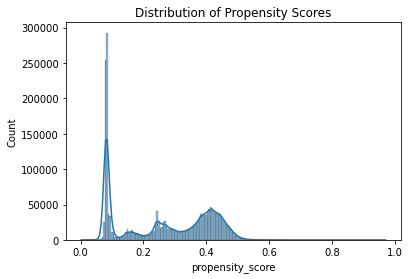

              DESYNPUF_ID  New_CHF_calc  propensity_score
0        00000B48BCF4AD29             0          0.247665
1        0000141F2FECE9BC             0          0.084169
2        000022FFDB0BE2C7             0          0.080930
3        00002BE498BED936             0          0.081565
4        00003539A5D77654             0          0.083633
...                   ...           ...               ...
2142282  FFFFE00DD0AA36E0             0          0.149918
2142283  FFFFE76452BF9DF6             0          0.081866
2142284  FFFFEE90E1B4D0DF             1          0.415798
2142285  FFFFF4859B6D7402             0          0.256050
2142286  FFFFFC6B1F91F551             0          0.081949

[2142287 rows x 3 columns]


In [106]:
from matplotlib import pyplot as plt
import seaborn as sns

# Create logistic regression model for propensity scores
logit = LogisticRegression()
final_df['propensity_score'] = logit.fit(final_df[covariates], final_df[outcome]).predict_proba(final_df[covariates])[:,1]

# Visualize propensity scores
sns.histplot(final_df['propensity_score'], kde=True)
plt.title('Distribution of Propensity Scores')
plt.show()

print(final_df[['DESYNPUF_ID', 'New_CHF_calc', 'propensity_score']])

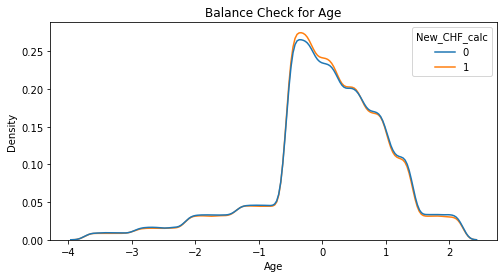

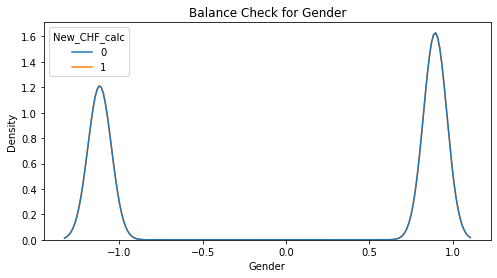

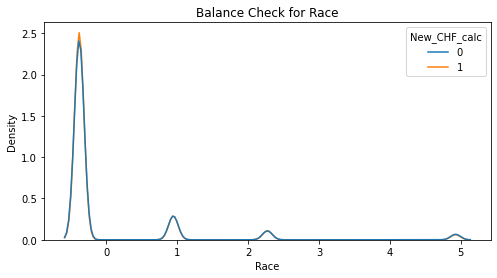

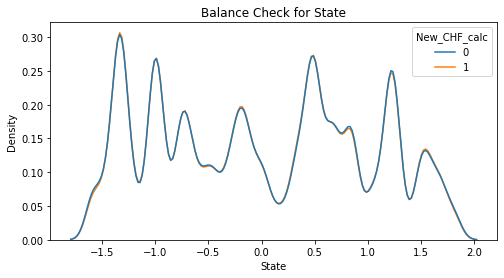

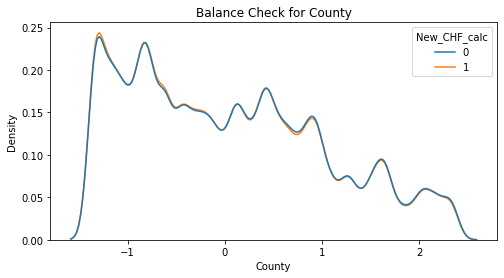

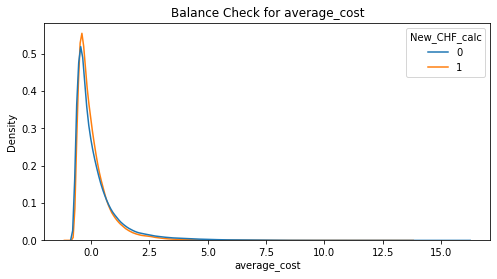

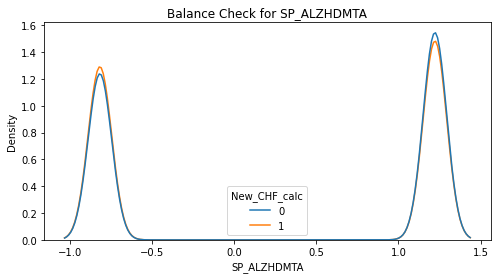

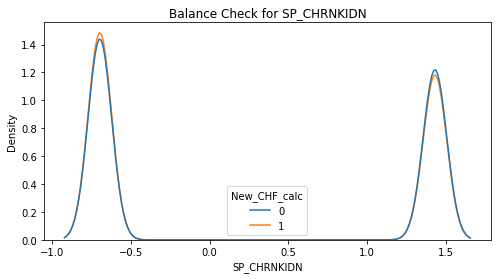

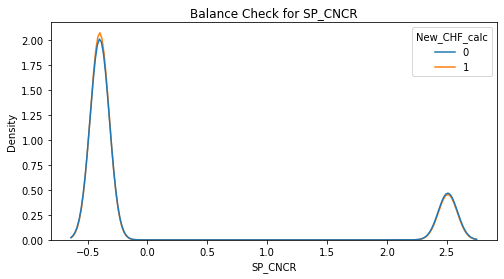

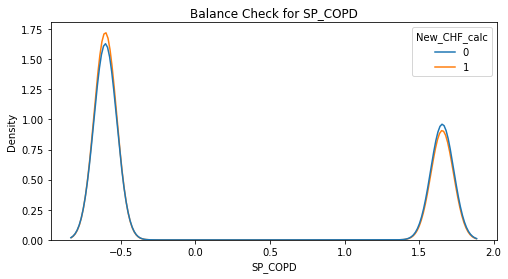

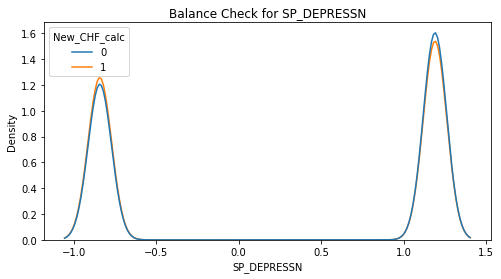

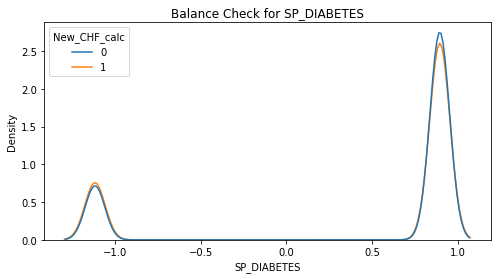

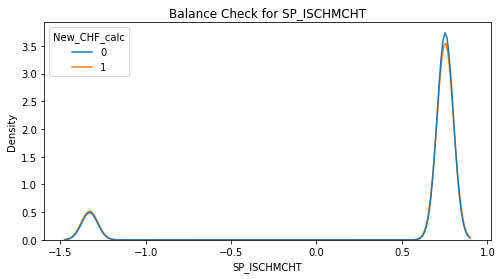

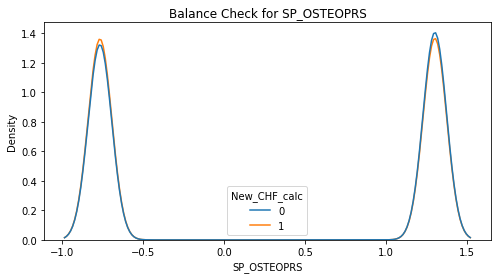

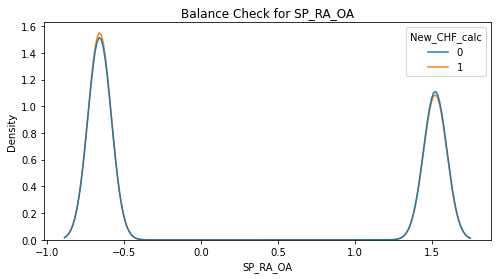

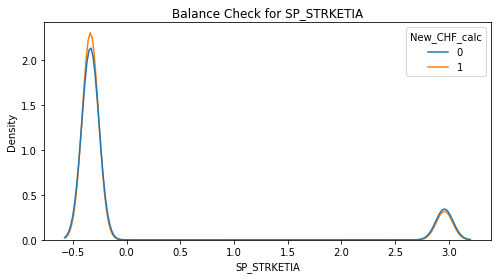

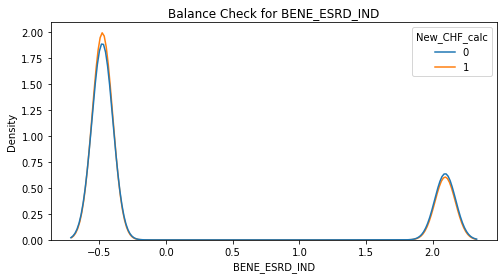

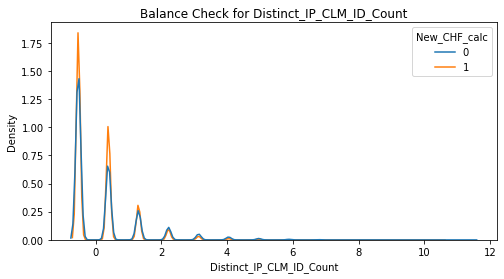

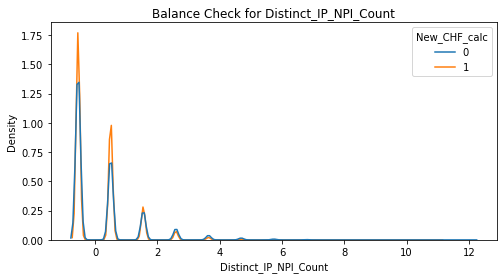

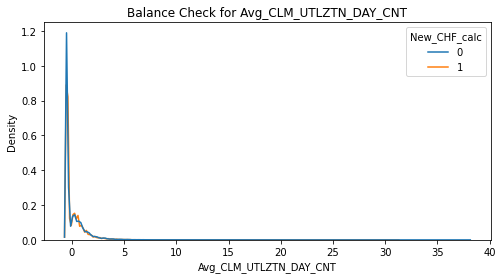

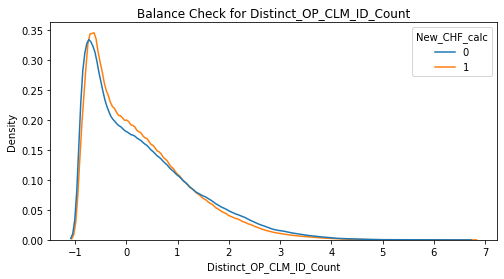

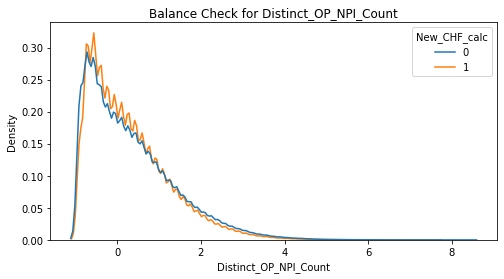

In [109]:
# Matching
treated = final_df[final_df['New_CHF_calc'] == 1].reset_index(drop=True)
control = final_df[final_df['New_CHF_calc'] == 0].reset_index(drop=True)

# Fit nearest neighbors model on control group
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors for treated group
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Create matched pairs
matched_control_indices = indices.flatten()
matched_control = control.iloc[matched_control_indices].reset_index(drop=True)

# Combine matched treated and control into one DataFrame
matched_data = pd.concat([treated, matched_control], ignore_index=True)

# Diagnostics: Check balance of covariates after matching
for covariate in covariates:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=matched_data, x=covariate, hue='New_CHF_calc')
    plt.title(f'Balance Check for {covariate}')
    plt.show()

In [110]:
# Calculate average costs for treated and control groups
average_cost_chf_pos = matched_data[matched_data['New_CHF_calc'] == 1]['total_cost'].mean()
average_cost_chf_neg = matched_data[matched_data['New_CHF_calc'] == 0]['total_cost'].mean()

print(f"Average Cost for patients with CHF: ${average_cost_chf_pos:.2f}")
print(f"Average Cost for patients without CHF: ${average_cost_chf_neg:.2f}")

# Calculate the average treatment effect on the treated (ATT)
att = average_cost_chf_pos - average_cost_chf_neg
print(f"Average Cost Difference between patients with and without CHF: ${att:.2f}")

Average Cost for patients with CHF: $15914.87
Average Cost for patients without CHF: $17781.07
Average Cost Difference between patients with and without CHF: $-1866.20


In [112]:
# Compare Costs
average_cost_treated = matched_data[matched_data['New_CHF_calc'] == 1]['total_cost'].mean()
average_cost_control = matched_data[matched_data['New_CHF_calc'] == 0]['total_cost'].mean()

print(f"Average Cost for (CHF): ${average_cost_treated:.2f}")
print(f"Average Cost for (Non-CHF): ${average_cost_control:.2f}")

# Calculate the average treatment effect on the treated (ATT)
att = average_cost_treated - average_cost_control
print(f"Average Intervention Effect on the CHF (AIT metric): ${att:.2f}")

# Bootstrap confidence intervals
n_bootstraps = 1000
att_bootstraps = []

for _ in range(n_bootstraps):
    bootstrap_sample = matched_data.sample(frac=1, replace=True)
    average_cost_treated_boot = bootstrap_sample[bootstrap_sample['New_CHF_calc'] == 1]['total_cost'].mean()
    average_cost_control_boot = bootstrap_sample[bootstrap_sample['New_CHF_calc'] == 0]['total_cost'].mean()
    att_bootstraps.append(average_cost_treated_boot - average_cost_control_boot)

ci_lower = np.percentile(att_bootstraps, 2.5)
ci_upper = np.percentile(att_bootstraps, 97.5)

print(f"95% CI for ATT: (${ci_lower:.2f}, ${ci_upper:.2f})")

Average Cost for (CHF): $15914.87
Average Cost for (Non-CHF): $17781.07
Average Intervention Effect on the CHF (AIT metric): $-1866.20



KeyboardInterrupt

